# COVID-19's Impact on Healthcare Accessibility
### By: Tristan Call and Maria Elena Aviles-Baquero

## Introductory

In [ ]:


# STEPS
# 1. Focus on Washington (for now aka. generalize code (as always))
# 2. create default values

# load data function: through MyPyTable()

# data analysis functions:
# group_by()
# get_column() - MyPyTable
# plotting - whatever we used in class
    # save_graph() function
# output result files (? TBD)

# summary_stats from MyPyTable

## Data Analysis

TODO:
- load in data to use
- create analysis functions (something that takes in specific attributes and returns them)

In [2]:
# some useful mysklearn package import statements and reloads
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.plot_utils
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import os
import pandas as pd

## Manipulate Data into Useable Format
The first thing we need to do is grab the data from the sas file and manipulate it into a format and size which is workable with our very much not optimized dataset. Part of this involves dropping rows with NaNs or -99s (seen but unanswered questions) in them ahead of time. Overall we aim to go from about 70,000 results to a more reasonable < 10,000.

In [3]:
# Grab the data
week21_filename = os.path.join("input_data", "pulse2020_puf_21.sas7bdat")
iterator = pd.read_sas(week21_filename, chunksize=5000)
alldata = []
for chunk in iterator:
    alldata.append(chunk)

relevant_attributes = ["TBIRTH_YEAR", "EGENDER", "RHISPANIC", "RRACE", "EEDUC", "INCOME", "DELAY", "NOTGET"]

# Grab a chunk of data with the attributes we are interested in, minus Nans, and save to a local file
data = alldata[0][["TBIRTH_YEAR", "EGENDER", "RHISPANIC", "RRACE", "EEDUC", "INCOME", "DELAY", "NOTGET"]]
working_data_filename = os.path.join("input_data", "week21_working.csv")
nafree_data = data.dropna()

# Get rid of -99 results (aka seen but not answered)
nafree_data = nafree_data[nafree_data.INCOME != -99]
nafree_data = nafree_data[nafree_data.DELAY != -99]
nafree_data = nafree_data[nafree_data.NOTGET != -99]
print(nafree_data)

# Save to file
nafree_data.to_csv(working_data_filename)

      TBIRTH_YEAR  EGENDER  RHISPANIC  RRACE  EEDUC  INCOME  DELAY  NOTGET
1          1969.0      2.0        1.0    1.0    7.0     6.0    1.0     2.0
2          1959.0      2.0        1.0    1.0    7.0     4.0    1.0     1.0
4          1967.0      1.0        1.0    1.0    4.0     6.0    2.0     2.0
5          1965.0      1.0        1.0    1.0    7.0     6.0    2.0     2.0
6          1962.0      2.0        1.0    2.0    4.0     1.0    2.0     2.0
...           ...      ...        ...    ...    ...     ...    ...     ...
4993       1964.0      2.0        1.0    1.0    4.0     1.0    2.0     2.0
4994       1984.0      1.0        1.0    1.0    4.0     7.0    1.0     1.0
4995       1973.0      1.0        1.0    1.0    6.0     8.0    2.0     2.0
4997       1976.0      2.0        1.0    1.0    3.0     3.0    1.0     1.0
4999       1958.0      2.0        1.0    1.0    7.0     5.0    2.0     2.0

[3909 rows x 8 columns]


## Organize the data
Next we want to get the data into a more useful format. Step one of this is chunk years into decades to have a reasonable number of attribute values for year according to the below:

years | label
-|-
1932-1941 | 1
1942-1951 | 2
1952-1961 | 3
1962-1971 | 4
1972-1981 | 5
1982-1991 | 6
1992-2002 | 7

Next we want to create a DELAYNOTGET column as a composite of delay and notget.

In [4]:
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Load the data into a mypytable for future analysis
overall_table = MyPyTable()
overall_table.load_from_file(working_data_filename)
overall_table.convert_to_numeric()

# Convert year into bigger categorical chunks
year_col = overall_table.get_column("TBIRTH_YEAR")
year_label = [x + 1 for x in range(7)]
cutoffs = [1932 + 10 * x for x in range(8)]
year_col = myutils.categorize_continuous_list(year_col, cutoffs, year_label)

# Create DELAYNOTGET column
delay = overall_table.get_column("DELAY")
notget = overall_table.get_column("NOTGET")
delaynotget = []
for i in range(len(delay)):
    if delay[i] == 1 or notget[i] == 1:
        delaynotget.append(1)
    else:
        delaynotget.append(2)
        
# Combine all the above into the overall_table
overall_table.column_names.append("DELAYNOTGET")
overall_table.data = [[overall_table.data[i][0]] + [year_col[i]] + overall_table.data[i][2:] + [delaynotget[i]] for i in range(len(year_col))]
# overall_table.pretty_print()

# Classification
In this section we will classify our results using our classifiers

## Visualizations

### Summary Statistics for the Attributes

In [6]:
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

# SHOULD I KEEP THE SUMMARY STATS? ARE THEY NECESSARY? WHAT DO THEY TELL US?

# use overall_table object declared above to compute the stats for all attributes
table_stats = overall_table.compute_summary_statistics(overall_table.column_names)
# print out the statistics table
table_stats.pretty_print()

items, values = myutils.get_item_frequency(overall_table.get_column("DELAYNOTGET"))
print(items)
print(values)
# add a graph?

attribute      min    max     mid         avg    median          std
-----------  -----  -----  ------  ----------  --------  -----------
                 1   4999  2500    2495.9          2487  1442.12
TBIRTH_YEAR      1      7     4       4.0967          4     1.55314
EGENDER          1      2     1.5     1.59964         2     0.489971
RHISPANIC        1      2     1.5     1.08314         1     0.276096
RRACE            1      4     2.5     1.31491         1     0.778868
EEDUC            1      7     4       5.33078         6     1.42407
INCOME           1      8     4.5     4.5559          5     2.07749
DELAY            1      2     1.5     1.65004         2     0.476958
NOTGET           1      2     1.5     1.74648         2     0.435025
DELAYNOTGET      1      2     1.5     1.61474         2     0.486658
[1, 2]
[1506, 2403]


(Add notes here regarding findings in statistics summary)

### Grouping the Data Into Those Who Received Care Without Delay and Those Who Did Not

In [10]:
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# get subtables group by whether or not an instance was delayed/didn't get care or did receive care without delay
group_names, subtables = overall_table.group_by("DELAYNOTGET")

# first subtable represents the instances where the individual got delayed care or did not get any
delayed_or_none = MyPyTable(overall_table.column_names, subtables[0])
# second subtable represents the instances where the individual got delayed care or did not get any
care_received = MyPyTable(overall_table.column_names, subtables[1])

# delayed_or_none.pretty_print()
# care_received.pretty_print()

### Birth Years Data and Observations Based on "DELAYNOTGET" Attribute Values

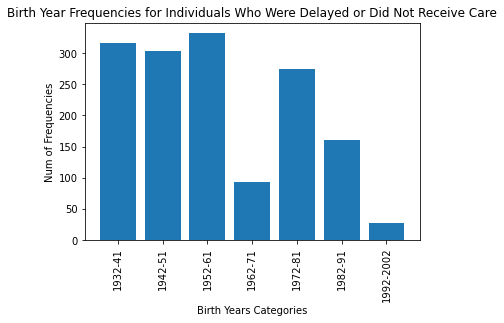

In [19]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

birth_years = ["1932-41", "1942-51", "1952-61", "1962-71", "1972-81", "1982-91", "1992-2002"]
# get the frequencies of each birth categories in the delayed/no care subtable
delay_items, birth_freq_delay = myutils.get_item_frequency(delayed_or_none.get_column("TBIRTH_YEAR"))
# frequencies of each birth categories in the care received subtable
# care_items, birth_freq_care = myutils.get_item_frequency(care_received.get_column("TBIRTH_YEAR"))

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(birth_years, birth_freq_delay, "Birth Years Categories", "Num of Frequencies", "Birth Year Frequencies for Individuals Who Were Delayed or Did Not Receive Care")
# plot_utils.plot_bar(birth_years, birth_freq_care, "Birth Years Categories", "Num of Frequencies", "Birth Year Frequencies for Individuals Who Received Care")

Remember, the values 1 to 7 have the following meanings:

Years | Label
-|-
1932-1941 | 1
1942-1951 | 2
1952-1961 | 3
1962-1971 | 4
1972-1981 | 5
1982-1991 | 6
1992-2002 | 7

(Add observations here regarding care to certain age groups)

### Race and Ethnicity of Individual Data and Observations Based on "DELAYNOTGET" Attribute Values

The identities of each race present in this data are labeled from 1 to 4:

Race | Label
-|-
White | 1
Black | 2
Asian | 3
Mixed; More than one of the above | 4



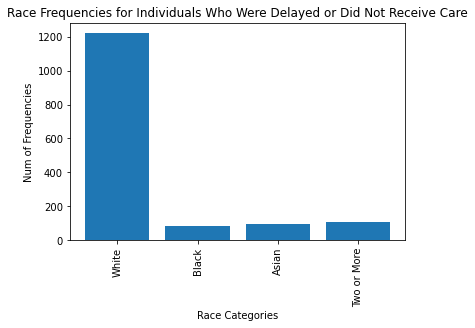

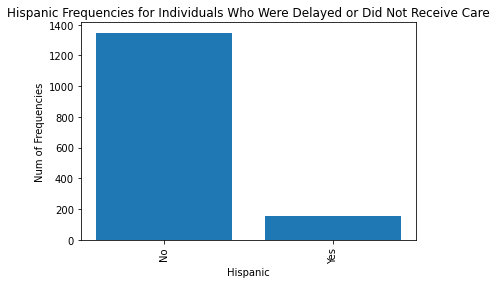

In [16]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Race
race_labels = ["White", "Black", "Asian", "Two or More"]
# get the frequencies of each race categories in the delayed/no care subtable
delay_items, race_freq_delay = myutils.get_item_frequency(delayed_or_none.get_column("RRACE"))
# frequencies of each race categories in the care received subtable
# care_items, race_freq_care = myutils.get_item_frequency(care_received.get_column("RRACE"))

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(race_labels, race_freq_delay, "Race Categories", "Num of Frequencies", "Race Frequencies for Individuals Who Were Delayed or Did Not Receive Care")
# plot_utils.plot_bar(race_labels, race_freq_care, "Race Categories", "Num of Frequencies", "Race Frequencies for Individuals Who Received Care")


# Ethnicity (Hispanic)
# 1 -> no ; 2 -> yes
hispanic_labels = ["No", "Yes"]
# get the frequencies of each hispanic categories in the delayed/no care subtable
delay_items, hisp_freq_delay = myutils.get_item_frequency(delayed_or_none.get_column("RHISPANIC"))
# frequencies of each hispanic categories in the care received subtable
# care_items, hisp_freq_care = myutils.get_item_frequency(care_received.get_column("RHISPANIC"))

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(hispanic_labels, hisp_freq_delay, "Hispanic", "Num of Frequencies", "Hispanic Frequencies for Individuals Who Were Delayed or Did Not Receive Care")
# plot_utils.plot_bar(hispanic_labels, hisp_freq_care, "Hispanic", "Num of Frequencies", "Hispanic Frequencies for Individuals Who Received Care")

(Add observations regarding race and ethnicity (hispanic))

### Gender of Individual Data and Observations Based on "DELAYNOTGET" Attribute Values
(Does not specify whether the individual is transgender or cisgender)

Gender/Sex | Label
-|-
Male | 1
Female | 2

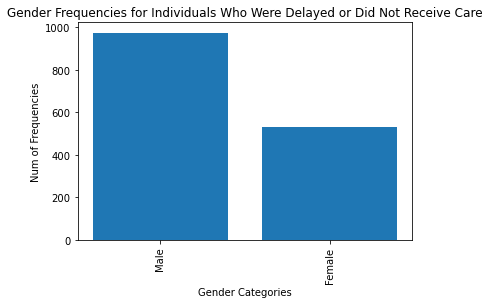

In [17]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Gender/Sex
sex_labels = ["Male", "Female"]
# get the frequencies of each gender categories in the delayed/no care subtable
delay_items, sex_freq_delay = myutils.get_item_frequency(delayed_or_none.get_column("EGENDER"))
# frequencies of each gender categories in the care received subtable
# care_items, sex_freq_care = myutils.get_item_frequency(care_received.get_column("EGENDER"))

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(sex_labels, sex_freq_delay, "Gender", "Num of Frequencies", "Gender Frequencies for Individuals Who Were Delayed or Did Not Receive Care")
# plot_utils.plot_bar(sex_labels, sex_freq_care, "Gender Categories", "Num of Frequencies", "Gender Frequencies for Individuals Who Received Care")

(Add observations regarding gender)

### Education Level Data and Observations Based on "DELAYNOTGET" Attribute Values

Education Level | Label
-|-
Less than high school | 1
Some high school | 2
High school graduate or equivalent | 3
Some college | 4
Associate's degree | 5
Bachelor's degree | 6
Graduate degree | 7

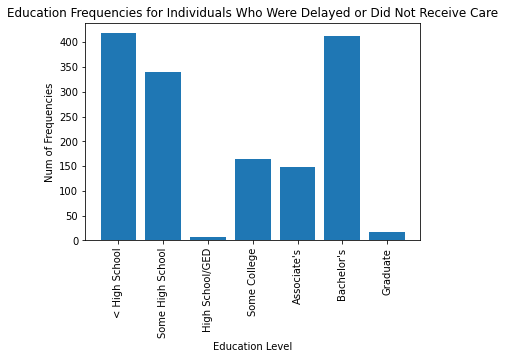

In [20]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Education
ed_labels = ["< High School", "Some High School", "High School/GED", "Some College", "Associate's", "Bachelor's", "Graduate"]
# get the frequencies of each education categories in the delayed/no care subtable
delay_items, ed_freq_delay = myutils.get_item_frequency(delayed_or_none.get_column("EEDUC"))
# frequencies of each education categories in the care received subtable
# care_items, ed_freq_care = myutils.get_item_frequency(care_received.get_column("EEDUC"))

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(ed_labels, ed_freq_delay, "Education Level", "Num of Frequencies", "Education Frequencies for Individuals Who Were Delayed or Did Not Receive Care")
# plot_utils.plot_bar(ed_labels, ed_freq_care, "Education Level", "Num of Frequencies", "Education Frequencies for Individuals Who Received Care")

(Add observations regarding education level here)

### Income Data and Observations Based on "DELAYNOTGET" Attribute Values

Income | Label
-|-
< 25,000 | 1
25,000 - 34,999 | 2
35,000 - 49,999 | 3
50,000 - 74,999 | 4
75,000 - 99,999 | 5
100,000 - 149,999 | 6
150,000 - 199,999 | 7
200,000 < | 8

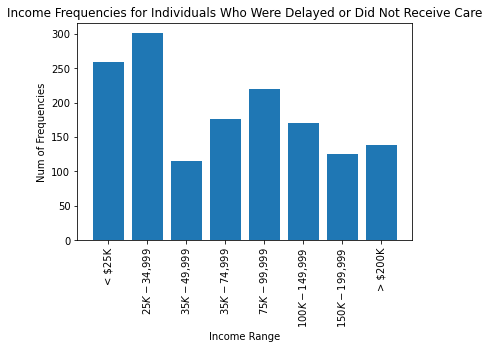

In [22]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Income
income_labels = ["< $25K", "$25K-$34,999", "$35K-$49,999", "$35K-$74,999", "$75K-$99,999", "$100K-$149,999", "$150K-$199,999", "> $200K"]
# get the frequencies of each income categories in the delayed/no care subtable
delay_items, income_freq_delay = myutils.get_item_frequency(delayed_or_none.get_column("INCOME"))
# frequencies of each income categories in the care received subtable
# care_items, income_freq_care = myutils.get_item_frequency(care_received.get_column("INCOME"))

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(income_labels, income_freq_delay, "Income Range", "Num of Frequencies", "Income Frequencies for Individuals Who Were Delayed or Did Not Receive Care")
# plot_utils.plot_bar(income_labels, income_freq_care, "Income Range", "Num of Frequencies", "Income Frequencies for Individuals Who Received Care")

(Add observations regarding income range and care)